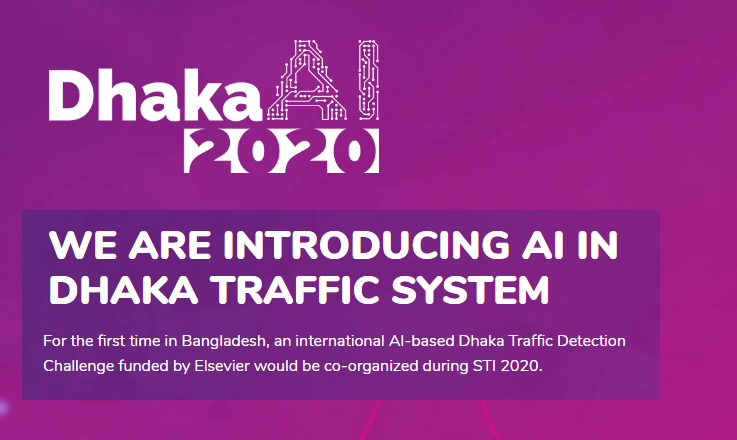



This notebook contains Ultralytics inference and training code for YOLOv3 in PyTorch for [Dhaka.ai-2020 Challenge.](https://dhaka-ai.com/index) **If you dont want to train the dataset you can simply skip to inference part.**

#1. Setup 
We have configure the YOLOV3 Ultralytics repository to train the traffic dataset. In this example we are going to use 30% of the dataset for training and testing.

## 1.1 Downloading `yolov3-wrapper-for-custom-data` from github
This will work as the main framework for the whole process

In [1]:
from IPython.display import clear_output

!rm -r sample_data
!git clone https://github.com/rifat963/yolov3-wrapper-for-custom-data.git

clear_output()

## 1.2 Downloading Your Processed Data
By this time you should be able to convert the original data into usable format in yolo v3 framework. For this you can follow the Data Preprocessing Notebook. You can do this downloading by two processes. For data pre processing, you can have  a look at the other notebook for data pre-processing. 

* **From Google Drive:** If you have your data already preprocessed in google drive, they you can smiply get the id of that data file and download in the `/content/yolov3-wrapper-for-custom-data/data/` directory. Remember you have to put the metadata files (`train.txt`, `valid.txt`, `test.txt`, `traffic.names`, `traffic.data`) in the `/content/yolov3-wrapper-for-custom-data/` directory

* **Uploading from Local Machine:** This is the brute force approach which can be pretty troublesome based on your internet connection. 

Now let's see how ou can download the preprocessed data to the appropriate directory. 

In [2]:
%cd /content/yolov3-wrapper-for-custom-data/data/

# !gdown --id 'ID of your preprocessed .zip file'
!gdown --id 'PUT Google Drive File ID of your preprocessed data here'

!unzip dhaka-traffic-yolo-v3.zip; rm dhaka-traffic-yolo-v3.zip;
clear_output()


# Setting the metadata files in their perfect place
%cp '/content/yolov3-wrapper-for-custom-data/data/metadata/train.txt' /content/yolov3-wrapper-for-custom-data/
%cp '/content/yolov3-wrapper-for-custom-data/data/metadata/valid.txt' /content/yolov3-wrapper-for-custom-data/
%cp '/content/yolov3-wrapper-for-custom-data/data/metadata/test.txt' /content/yolov3-wrapper-for-custom-data/
%cp '/content/yolov3-wrapper-for-custom-data/data/metadata/traffic.names' /content/yolov3-wrapper-for-custom-data/
%cp '/content/yolov3-wrapper-for-custom-data/data/metadata/traffic.data' /content/yolov3-wrapper-for-custom-data/

## 1.3 Changing Configuration File: 
 Now change the number of classes in the configuration file in `/content/yolov3-wrapper-for-custom-data/cfg/yolov3-spp-23cls.cfg`

 Several Changes: 
 1. **Number of Classes:** Change the classes attribute in line numbers $643, 729 $ and $ 816$ from $18$ to $21$ because now we are training with complete 21 clases

 2. **Change of filter number:** Change the `filters` attribute in the line numbers $636, 722 $ and $ 809$ from $69$ to $78.$ Previously for 18 class it was $(18+5)*3=69$ whereas now it will be $(21+5)*3 = 78$ 

## 1.4 Donwloading Pre-trained Weights: 
Similarly we download the pre trained weights for the model and we put them in ` /content/yolov3-wrapper-for-custom-data/cfg/weights`

In [ ]:
%cd /content/yolov3-wrapper-for-custom-data/weights/
!gdown --id 1UcR-zVoMs7DH5dj3N1bswkiQTA4dmKF4

# 2. Training
Here in the following segment of code, the training starts with the initial weights of  <font color ="blue">`weights/yolov3-spp-ultralytics.pt` </font>


Now just run the following segment of code and voila !!!
Don't forget to play with the parameters :D 

In [ ]:
%cd /content/yolov3-wrapper-for-custom-data

!python train.py --cfg cfg/yolov3-spp-23cls.cfg \
                 --data traffic.data \
                 --epochs 2 \
                 --batch-size 8 \
                 --weights weights/yolov3-spp-ultralytics.pt \
                 --name yolov3-traffic\

# 3. Inference Only

If you want to just produce predictions without training, you can simply skip the training and download pre-trained weights for testing and inference in the followoing segment of code. <font color="red">Beaware, if you want to download the best pretrained weights and want to predict on them, you again have to reverse the changes of `.cfg` file that you have done earlier because it was trained on 18 class. </font>

In [ ]:
%cd /content/yolov3-wrapper-for-custom-data/weights

!gdown --id 1n09SGMAsSQ4Gv9rezRUkd4MzF0qauF0y
%cd ..

In [ ]:
# Here is the code to predict the output on test set based on the pre trained model. 
!python detect.py --save-txt \
                  --names traffic.names \
                  --img-size 1024 \
                  --cfg cfg/yolov3-spp-23cls.cfg \
                  --weights weights/best_yolov3-traffic.pt \
                  --source data/test

All the results are in folder: <font color="red">`/content/yolov3-wrapper-for-custom-data/output/` </font>

# 4. Test Submissions:
 You can test the performance of the trained model on the validation set. The following set of code blocks caclulates **mAP@0.5 (Mean Average Precision @ threshold 0.5)** for the validation set. 

In [ ]:
!python test.py -h

In [ ]:
# Calling test.py to evaluate the model on validation set. 
%cd /content/yolov3-wrapper-for-custom-data/

!python test.py --data traffic.data \
                --cfg cfg/yolov3-spp-23cls.cfg \
                --weights weights/best_yolov3-traffic.pt \
                --img 1024 \
                --augment

# 5. Submission

This part of the code deals with making the submission file. Remember, the actual yolo v3 model outpus in the format  `(object-id) (score) (x-centre) (y-centre) (width) (height)` in each line for each object in the text label file. However, in the competition, you need to submit in this format `(image_name) (object_name) (xmin) (ymin) (xmax) (ymax) (width) (height)` for each line for each object in a `.csv` file. Feel free to unfold the code below and have a look at it. 


In [11]:
from models import *  
from utils.datasets import *
from utils.utils import *

def detect(save_img=False):
    imgsz = opt.img_size 
    out, source, weights, half, view_img, save_txt = opt.output, opt.source, opt.weights, opt.half, opt.view_img, opt.save_txt

    # Initialize
    device = torch_utils.select_device(opt.device)
    if os.path.exists(out):
        shutil.rmtree(out)  # delete output folder
    os.makedirs(out)  # make new output folder

    # Initialize model
    model = Darknet(opt.cfg, imgsz)

    # Load weights
    attempt_download(weights)
    if weights.endswith('.pt'):  # pytorch format
        model.load_state_dict(torch.load(weights, map_location=device)['model'])
    else:  # darknet format
        load_darknet_weights(model, weights)

    
    # Eval mode
    model.to(device).eval()

    # Half precision
    half = half and device.type != 'cpu'  # half precision only supported on CUDA
    if half:
        model.half()

    # Set Dataloader
    vid_path, vid_writer = None, None
    save_img = True
    dataset = LoadImages(source, img_size=imgsz)

    # Get names and colors
    names = load_classes(opt.names)
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

    # Run inference
    t0 = time.time()
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img.half() if half else img.float()) if device.type != 'cpu' else None  # run once

    results=[]
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = torch_utils.time_synchronized()
        pred = model(img, augment=opt.augment)[0]
        t2 = torch_utils.time_synchronized()

        # to float
        if half:
            pred = pred.float()

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres,
                                   multi_label=False, classes=opt.classes, agnostic=opt.agnostic_nms)

        
        # Process detections
        for i, det in enumerate(pred):  # detections for image i
            
            p, s, im0 = path, '', im0s          

            save_path = str(Path(out) / Path(p).name)
            #print(p)
            s += '%gx%g ' % img.shape[2:]  # print string
            #print(s)
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  #  normalization gain whwh
            if det is not None and len(det):
                # Rescale boxes from imgsz to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += '%g %ss, ' % (n, names[int(c)])  # add to string

                xmin = []
                ymin = []
                xmax = []
                ymax = []
                scores = []
                labels_value=[]
                image_ids=[]
                # Write results
                for *xyxy, conf, cls in det:
                    if save_txt:  # Write to file
                        
                        conf_score = '%.2f' % (conf)
                        label_with_cls = '%s' % (names[int(cls)])
                        
                        labels_value.append(label_with_cls)
                        
                        xmin.append(int(xyxy[0]))
                        ymin.append(int(xyxy[1]))
                        xmax.append(int(xyxy[2]))
                        ymax.append(int(xyxy[3]))
                        
                        scores.append(conf_score)
                        image_ids.append(save_path)

                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        with open(save_path[:save_path.rfind('.')] + '.txt', 'a') as file:
                            file.write(('%g ' * 5 + '\n') % (cls, *xywh))  # label format

                    if save_img or view_img:  # Add bbox to image
                        label = '%s %.2f' % (names[int(cls)], conf)
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)])

            # Print time (inference + NMS)
            print('%sDone. (%.3fs)' % (s, t2 - t1))

            # Stream results
            if view_img:
                cv2.imshow(p, im0)
                if cv2.waitKey(1) == ord('q'):  # q to quit
                    raise StopIteration

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'images':
                    cv2.imwrite(save_path, im0)
        result = {
            'image_id': image_ids,
            'score': scores,
            'class': labels_value,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax

            }

        results.append(result)

    if save_txt or save_img:
        print('Results saved to %s' % os.getcwd() + os.sep + out)

    print('Done. (%.3fs)' % (time.time() - t0))
    return results

In [12]:
# Setting up parameters for inference /submission
class opt:
    cfg='/content/yolov3-wrapper-for-custom-data/cfg/yolov3-spp-23cls.cfg'
    names='traffic.names'
    weights='weights/best_yolov3-traffic.pt'
    source='data/test'
    save_txt=True
    output='output'  # Output directory of the results
    classes=False
    img_size=1024    # Inference Imag Size
    conf_thres=0.3
    iou_thres=0.6
    fourcc='mp4v'
    half=False
    device=''
    view_img=False
    agnostic_nms=False
    augment=False


In [ ]:
# predict results
with torch.no_grad():
    res=detect()

### 5.1 Formatting the Submission File

In the submission file you need to have to following headers with values



*   `image_id:` image file name
*   `class:` object name like `rickshaw` or `bus`
*   `score:` confidence score of the object detection
*   `xmin`
*   `ymin`
*   `xmax`
*   `ymax`
*   `height`
*   `width`

**Remember all the test images are rescaled into 1024x1024 so the bounding boxes must be scaled for 1024x1024 image size**




## 5.2 Writing the Submission File

In [ ]:
import pandas as pd
import numpy as np

append_data=[]

for i in range(len(res)):
  df = pd.DataFrame(res[i], columns = ['image_id','class','score','xmin','ymin','xmax','ymax'])
  append_data.append(df)

finl_results=pd.concat(append_data)
finl_results.image_id = [x.strip('output/') for x in finl_results.image_id]

finl_results['width'] = 1024
finl_results['height'] = 1024

print(f'Number of Objects Detected: {finl_results.shape[0]}')

# Saving the submission file with timestamp
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y-%m-%d %H:%M:%S")

finl_results.to_csv(f'{timestamp} submission.csv', index=False)
print('Submission file is written Successfully!\n\n Sneak Peak at Submission File :)')

finl_results.head()